# Players Template

## Environment Setup and Import

In [6]:
import os
print(os.getcwd())

c:\Users\subsc\Documents\_work\FieldDay\OpenGameData\opengamedata-samples\templates\players


In [7]:
# Standard Libraries
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile

In [8]:
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats

In [9]:
# OGD Libraries
from OGDUtils.general.fileio import FileAPI, FileTypes

Change pandas `max_rows` and `max_columns`

In [10]:
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

## Data Import

Please change the settings below to configure which game/server location you want to use.

<!-- `ogd_server` : The file server that contains the actual data files -->
* `game_id` : The game whose data you want to access.
* `mode` : The kind of data you want to retrieve. Should be one of `FileTypes.PLAYER`, `FileTypes.POPULATION`, `FileTypes.SESSION`, `FileTypes.EVENTS` or `FileTypes.ALL_EVENTS`

Server Settings

In [49]:
game_id = 'AQUALAB'
mode    = FileTypes.PLAYER

In [50]:
months_list = FileAPI.GetAvailableMonths(game_id)
print(f"The available months are:")
pprint(months_list, compact=True)

The available months are:
['4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021',
 '11/2021', '12/2021', '1/2022', '2/2022', '3/2022', '4/2022', '5/2022',
 '6/2022', '7/2022', '8/2022', '9/2022', '10/2022', '11/2022', '12/2022',
 '1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', '7/2023', '8/2023',
 '9/2023', '10/2023', '11/2023', '12/2023', '1/2024']


Dataset Selection & Download

In [51]:
month = 1
year = 2024

# download the file if it doesn't exist.
zip_file, dataset_name = FileAPI.DownloadZippedDataset(game_id, month, year, mode)

Found the file AQUALAB_20240101_to_20240131_df72162_player-features.zip locally, nothing will be downloaded.


In [52]:
zip_name = zip_file.filename
print(zip_name)

AQUALAB_20240101_to_20240131_df72162_player-features.zip


In [53]:
raw_data = pd.DataFrame()

# Open TSV from the zip file.
tsv_name = f"{zip_name[:zip_name.rfind('.')]}.tsv"
with zip_file.open(f"{dataset_name}/{tsv_name}") as tsv_file:
    raw_data = pd.read_csv(tsv_file, sep='\t')
    data_readme = zip_file.read(f"{dataset_name}/readme.md")
zip_file.close()

## Data Transforms & Cleaning

### Type Conversions

In [54]:
typed_data = raw_data.copy()
for col, dtype in zip(raw_data, raw_data.dtypes):
  if dtype == "string" or dtype == "object":
    try:
      typed_data[col] = pd.to_timedelta(raw_data[col])
    except:
      try:
        typed_data[col] = pd.to_numeric(raw_data[col])
      except:
        pass

print(f"This dataframe contains data of the following types:\n{typed_data.dtypes.unique()}\n")
print(f"Per feature, the data types are:\n{typed_data.dtypes}")

This dataframe contains data of the following types:
[dtype('O') dtype('int64') dtype('<m8[ns]') dtype('float64')]

Per feature, the data types are:
PlayerID                                             object
SessionCount                                          int64
ActiveTime                                  timedelta64[ns]
JobsCompleted                                        object
SessionDiveSitesCount                                 int64
                                                 ...       
job60_JobsAttempted-num-completes                     int64
job60_JobsAttempted-percent-complete                  int64
job60_JobsAttempted-avg-time-per-attempt            float64
job60_JobsAttempted-std-dev-per-attempt               int64
job60_JobsAttempted-job-difficulties                 object
Length: 1359, dtype: object


Workable Dataframe After Dropping NAs

In [55]:
df_session = typed_data.dropna()


### Outlier Checking

In [58]:
#Parameters for cleaning

#@markdown Type a perjob feature name here
Interested_perjobfeature = 'JobsAttempted-num-complete'#@param {type:"string"}
#@markdown Does it have a corresponding aggreation feature with same name? Check it if yes.
Answer  = True#@param {type:"boolean"}
id_columns = pd.Index(["SessionID", "PlayerID"])

In [59]:
#find outliers of what columns
outlier = 4000 #@param {type:"integer"}
target_columns = [col for col in df_session.columns if Interested_perjobfeature in col]
bigoutliers = np.where(df_session[target_columns].ge(outlier)) 
#df of outliers
df_session[target_columns].iloc[bigoutliers]

""


In [60]:
#@markdown Do you want to filter player list?
Answer  = False#@param {type:"boolean"}
#@markdown Please change the file path if your player list is located differently.
PL_Path = "PlayerList.txt"#@param {type:"string"}
if Answer:
  player_list = pd.read_csv(JUPYTER_DIR / Path(PL_Path), sep='t', names=["Player"])
  raw_data = raw_data[raw_data.PlayerId.isin()]

## Overview

In [61]:
#split depending on prefix, clean columns
cols_split = []
for col in df_session.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  if prefix.startswith('job') or prefix.startswith('int') or prefix.startswith('obj') \
  or prefix.startswith('SA')  or prefix.startswith('Q'):
    cols_split.append(pieces[1])
  else:
    cols_split.append(col)
col_set = Counter(cols_split)
print(f"{len(df_session.columns)} Columns in {len(col_set)} groups:")
pprint(col_set, compact=False)

1359 Columns in 39 groups:
Counter({'JobActiveTime': 61,
         'JobArgumentationTime': 61,
         'JobCompletionTime': 61,
         'JobDiveSitesCount': 61,
         'JobDiveTime': 61,
         'JobExperimentationTime': 61,
         'JobGuideCount': 61,
         'JobHelpCount': 61,
         'JobHelpCount-ByTask': 61,
         'JobLocationChanges': 61,
         'JobLocationChanges-ByTask': 61,
         'JobModelingTime': 61,
         'JobTasksCompleted': 61,
         'SyncCompletionTime': 61,
         'JobsAttempted': 61,
         'JobsAttempted-job-name': 61,
         'JobsAttempted-num-starts': 61,
         'JobsAttempted-num-completes': 61,
         'JobsAttempted-percent-complete': 61,
         'JobsAttempted-avg-time-per-attempt': 61,
         'JobsAttempted-std-dev-per-attempt': 61,
         'JobsAttempted-job-difficulties': 61,
         'PlayerID': 1,
         'SessionCount': 1,
         'ActiveTime': 1,
         'JobsCompleted': 1,
         'SessionDiveSitesCount': 1,
     

In [62]:
#data types in each column
df_session.dtypes

PlayerID                                             object
SessionCount                                          int64
ActiveTime                                  timedelta64[ns]
JobsCompleted                                        object
SessionDiveSitesCount                                 int64
                                                 ...       
job60_JobsAttempted-num-completes                     int64
job60_JobsAttempted-percent-complete                  int64
job60_JobsAttempted-avg-time-per-attempt            float64
job60_JobsAttempted-std-dev-per-attempt               int64
job60_JobsAttempted-job-difficulties                 object
Length: 1359, dtype: object

Sample Rows

In [63]:
rows_to_show = 10
df_session.head(rows_to_show)

PlayerID  SessionCount               ActiveTime  \
1      AbleSphynx             1   0 days 00:00:33.915000   
2     AbsentTroop             1   0 days 00:05:18.555000   
3   AbsorbedPulse             5  14 days 02:02:11.689000   
4     AbsurdOrder             6 -1 days +18:43:03.607000   
5    AccusingSilo             1   0 days 00:00:55.830000   
6     AchingNiche             1   0 days 00:19:01.885000   
7         AcidCap             1   0 days 00:03:11.707000   
8      ActiveCorn             2 -5 days +00:53:29.777000   
9     ActualShelf             1   0 days 01:11:10.471000   
10    AdequateHay             1   0 days 00:06:09.838000   

                                        JobsCompleted  SessionDiveSitesCount  \
1                                                  []                      0   
2                                                  []                      0   
3           ["kelp-welcome", "kelp-bull-kelp-forest"]                      2   
4   ["coral-turtle-stability", "displaced-reef", "...                     13   
5                                                  []                      0   
6   ["kelp-welcome", "kelp-bull-kelp-forest", "kel...                      1   
7                                                  []                      0   
8   ["coral-turtle-population", "kelp-energy", "ar...                      6   
9   ["kelp-welcome", "kelp-bull-kelp-forest", "kel...                     10   
10                                   ["kelp-welcome"]                      0   

    SessionGuideCount  SessionHelpCount SessionID  SessionJobsCompleted  \
1                   0                 0    player                     0   
2                   0                 0    player                     0   
3                   0                13    player                     2   
4                   0                65    player                    48   
5                   0                 0    player                     0   
6                   0                 4    player                     4   
7                   0                 0    player                     0   
8                   0                14    player                     7   
9                   0                17    player                    16   
10                  0                 2    player                     1   

    SwitchJobsCount                       TopJobCompletionDestinations  \
1                 0                                                 {}   
2                 1                                                 {}   
3                 8  {\kelp-welcome\": {\"no-active-job\": [\"Absor...   
4               101  {\coral-turtle-stability\": {\"no-active-job\"...   
5                 0                                                 {}   
6                 8  {\kelp-welcome\": {\"no-active-job\": [\"Achin...   
7                 1                                                 {}   
8                16  {\coral-turtle-population\": {\"no-active-job\...   
9                33  {\kelp-welcome\": {\"no-active-job\": [\"Actua...   
10                2                                                 {}   

                             TopJobSwitchDestinations TotalArgumentationTime  \
1                                                  {}        0 days 00:00:00   
2   {\no-active-job\": {\"kelp-welcome\": [\"Absen...        0 days 00:00:00   
3   {\no-active-job\": {\"kelp-welcome\": [\"Absor... 0 days 00:06:16.405000   
4   {\no-active-job\": {\"arctic-missing-whale\": ... 0 days 01:23:14.322000   
5                                                  {}        0 days 00:00:00   
6   {\no-active-job\": {\"kelp-welcome\": [\"Achin... 0 days 00:02:22.993000   
7   {\no-active-job\": {\"kelp-welcome\": [\"AcidC...        0 days 00:00:00   
8   {\arctic-missing-whale\": {\"coral-turtle-popu... 1 days 11:50:42.067000   
9   {\no-active-job\": {\"kelp-welcome\": [\"Actua... 0 days 00:14:15.931000   
10  {\no-active-job\": {\"

In [64]:
df_session.describe(include='all')

PlayerID  SessionCount                 ActiveTime JobsCompleted  \
count         2658   2658.000000                       2658          2658   
unique        2658           NaN                        NaN           502   
top     AbleSphynx           NaN                        NaN            []   
freq             1           NaN                        NaN          1415   
mean           NaN      2.133183  0 days 10:05:57.260182844           NaN   
std            NaN      3.084243  3 days 06:41:31.545061179           NaN   
min            NaN      1.000000  -21 days +00:10:20.504000           NaN   
25%            NaN      1.000000     0 days 00:02:00.054750           NaN   
50%            NaN      1.000000     0 days 00:07:13.728000           NaN   
75%            NaN      2.000000     0 days 00:25:56.514250           NaN   
max            NaN     44.000000    28 days 19:31:08.398000           NaN   

        SessionDiveSitesCount  SessionGuideCount  SessionHelpCount SessionID  \
count             2658.000000             2658.0       2658.000000      2658   
unique                    NaN                NaN               NaN         1   
top                       NaN                NaN               NaN    player   
freq                      NaN                NaN               NaN      2658   
mean                 2.239278                0.0          7.467645       NaN   
std                  3.508784                0.0         17.848268       NaN   
min                  0.000000                0.0          0.000000       NaN   
25%                  0.000000                0.0          0.000000       NaN   
50%                  1.000000                0.0          1.000000       NaN   
75%                  2.000000                0.0          6.000000       NaN   
max                 13.000000                0.0        225.000000       NaN   

        SessionJobsCompleted  SwitchJobsCount TopJobCompletionDestinations  \
count            2658.000000      2658.000000                         2658   
unique                   NaN              NaN                         1126   
top                      NaN              NaN                           {}   
freq                     NaN              NaN                         1533   
mean                3.559443         8.972912                          NaN   
std                 7.958093        18.538571                          NaN   
min                 0.000000         0.000000                          NaN   
25%                 0.000000         1.000000                          NaN   
50%                 0.000000         2.000000                          NaN   
75%                 3.000000         8.000000                          NaN   
max                55.000000       167.000000                          NaN   

       TopJobSwitchDestinations     TotalArgumentationTime  \
count                      2658                       2658   
unique                     2142                        NaN   
top                          {}                        NaN   
freq                        517                        NaN   
mean                        NaN  0 days 00:47:56.545596313   
std                         NaN  0 days 05:44:41.429649426   
min                         NaN            0 days 00:00:00   
25%                         NaN            0 days 00:00:00   
50%                         NaN     0 days 00:00:17.597000   
75%                         NaN     0 days 00:04:25.211750   
max                         NaN     5 days 03:26:53.458000   

                    TotalDiveTime   TotalExperimentationTime  \
count                        2658                       2658   
unique                        NaN                        NaN   
top                           NaN                        NaN   
freq                          NaN                        NaN   
mean    0 days 00:02:41.181048156  0 days 00:15:57.818250564   
std     0 days 00:44:55.267003323  0 days 02:31:58.6393132

#### Session features

In [65]:
#Data frame to analyze
target = 'job' #@param {type:"string"}
target_columns = df_session.columns[~df_session.columns.str.contains(target)]
df_Aggregate = df_session[target_columns].copy()
df_Aggregate

,PlayerID,SessionCount,ActiveTime,JobsCompleted,SessionDiveSitesCount,SessionGuideCount,SessionHelpCount,SessionID,SessionJobsCompleted,SwitchJobsCount,TopJobCompletionDestinations,TopJobSwitchDestinations,TotalArgumentationTime,TotalDiveTime,TotalExperimentationTime,UserAvgSessionDuration,UserTotalSessionDuration
1,AbleSphynx,1,0 days 00:00:33.915000,[],0,0,0,player,0,0,{},{},0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,33.9150,33.915
2,AbsentTroop,1,0 days 00:05:18.555000,[],0,0,0,player,0,1,{},"{\no-active-job\"": {\""kelp-welcome\"": [\""Absen...",0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,318.5550,318.555
3,AbsorbedPulse,5,14 days 02:02:11.689000,"[""kelp-welcome"", ""kelp-bull-kelp-forest""]",2,0,13,player,2,8,"{\kelp-welcome\"": {\""no-active-job\"": [\""Absor...","{\no-active-job\"": {\""kelp-welcome\"": [\""Absor...",0 days 00:06:16.405000,0 days 00:00:22.454000,0 days 00:02:00.509000,14945.5794,74727.897
4,AbsurdOrder,6,-1 days +18:43:03.607000,"[""coral-turtle-stability"", ""displaced-reef"", ""...",13,0,65,player,48,101,"{\coral-turtle-stability\"": {\""no-active-job\""...","{\no-active-job\"": {\""arctic-missing-whale\"": ...",0 days 01:23:14.322000,0 days 00:06:03.101000,0 days 00:23:47.185000,5261.7910,31570.746
5,AccusingSilo,1,0 days 00:00:55.830000,[],0,0,0,player,0,0,{},{},0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,55.8300,55.830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2654,YawningGator,1,0 days 00:04:38.576000,[],0,0,0,player,0,1,{},"{\no-active-job\"": {\""kelp-welcome\"": [\""Yawni...",0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,423.3030,423.303
2655,YearlyGravel,1,0 days 00:06:18.063000,[],0,0,1,player,0,1,{},"{\no-active-job\"": {\""kelp-welcome\"": [\""Yearl...",0 days 00:00:00,0 days 00:00:00,0 days 00:00:48.120000,13257.2610,13257.261
2656,YouthfulBook,1,0 days 00:01:11.897000,[],1,0,0,player,0,1,{},{},0 days 00:00:00,0 days 00:00:07.696000,0 days 00:00:00,239.6580,239.658
2657,ZestyLag,1,0 days 00:10:44.886000,[],0,0,4,player,0,1,{},"{\no-active-job\"": {\""kelp-welcome\"": [\""Zesty...",0 days 00:00:56.324000,0 days 00:00:00,0 days 00:01:02.004000,644.8860,644.886


Amount of players

In [66]:
#Amount of unique PlayerIDs - amount of players
len(df_Aggregate['PlayerID'])

2658

How long did they play?

In [67]:
df_column = df_session['UserTotalSessionDuration'] #column must be integers

## Visualizations

The average time spent was 24967.666666666668 seconds


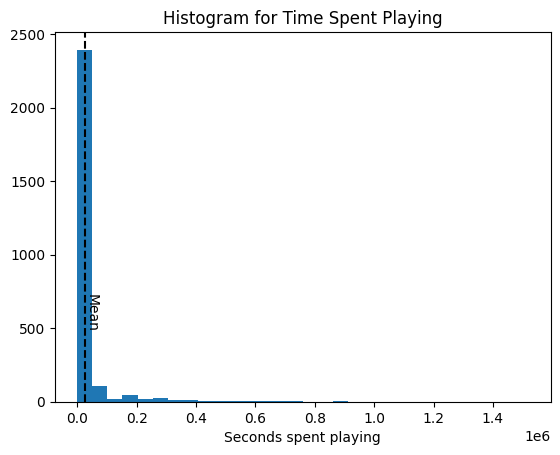

In [68]:
#jobs completed
f, ax = plt.subplots()
ax.hist(df_column, bins=30)
ax.axvline(x=df_column.mean(), linestyle='--', color='k', label="Median")
ax.text(x=df_column.mean() + 0.25, y=500, s="Mean", rotation=-90)
ax.set_xlabel("Seconds spent playing")
ax.set_title("Histogram for Time Spent Playing")
print(f'The average time spent was {df_column.mean()} seconds')

How far did the players get?

In [69]:

#@parameter
df_column = df_session['SessionJobsCompleted'] #column must be integers

The average amount of levels completed: 3.559443190368698


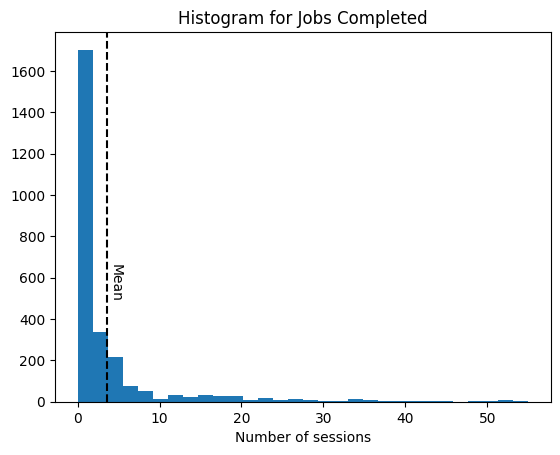

In [70]:
#jobs completed
f, ax = plt.subplots()
ax.hist(df_column, bins=30)
ax.axvline(x=df_column.mean(), linestyle='--', color='k', label="Median")
ax.text(x=df_column.mean() + 0.25, y=500, s="Mean", rotation=-90)
ax.set_xlabel("Number of sessions")
ax.set_title("Histogram for Jobs Completed")
print(f'The average amount of levels completed: {df_column.mean()}')

X vs Y Scatter Plot

In [71]:
#scatter plot columns
col1 = 'SessionHelpCount' #@param{type:"string"}
col2 = 'SessionJobsCompleted'#@param{type:"string"}

Slope of line: 3.559443190368705


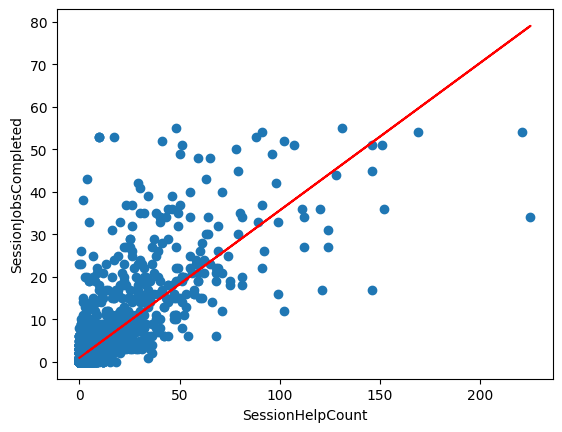

In [72]:
plt.scatter(df_session[col1], df_session[col2])
m, b = np.polyfit(df_session[col1], df_session[col2], 1)
plt.plot(df_session[col1], m*df_session[col1]+b, color = 'red')
plt.xlabel(col1)
plt.ylabel(col2)
print(f'Slope of line: {(m*df_session[col1]+b).mean()}')

Amount of Sessions vs Avg Length of Session

In [73]:
#scatter plot columns
col1 = 'SessionCount' #@param{type:"string"}
col2 = 'UserAvgSessionDuration'#@param{type:"string"}

Slope of line: 9347.56336265919


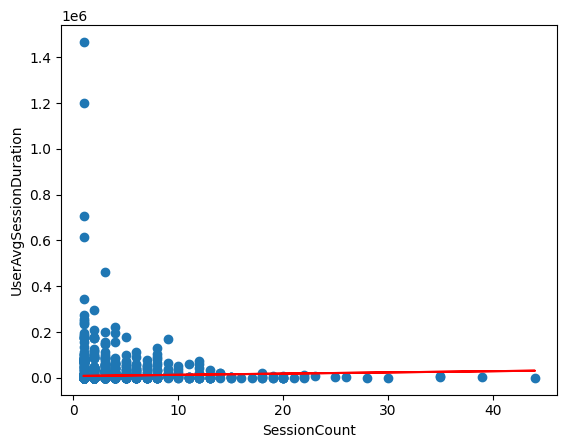

In [74]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])
m, b = np.polyfit(df_Aggregate[col1], df_Aggregate[col2], 1)
plt.plot(df_Aggregate[col1], m*df_Aggregate[col1]+b, color = 'red')
plt.xlabel(col1)
plt.ylabel(col2)
print(f'Slope of line: {(m*df_session[col1]+b).mean()}')

C:\Users\subsc\AppData\Local\Temp\ipykernel_27400\3084540358.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_Aggregate[target_cols].hist(ax=ax)


array([[<Axes: title={'center': 'SessionDiveSitesCount'}>,
        <Axes: title={'center': 'SessionGuideCount'}>,
        <Axes: title={'center': 'SessionHelpCount'}>],
       [<Axes: title={'center': 'SessionJobsCompleted'}>,
        <Axes: title={'center': 'SwitchJobsCount'}>,
        <Axes: title={'center': 'UserAvgSessionDuration'}>],
       [<Axes: title={'center': 'UserTotalSessionDuration'}>, <Axes: >,
        <Axes: >]], dtype=object)

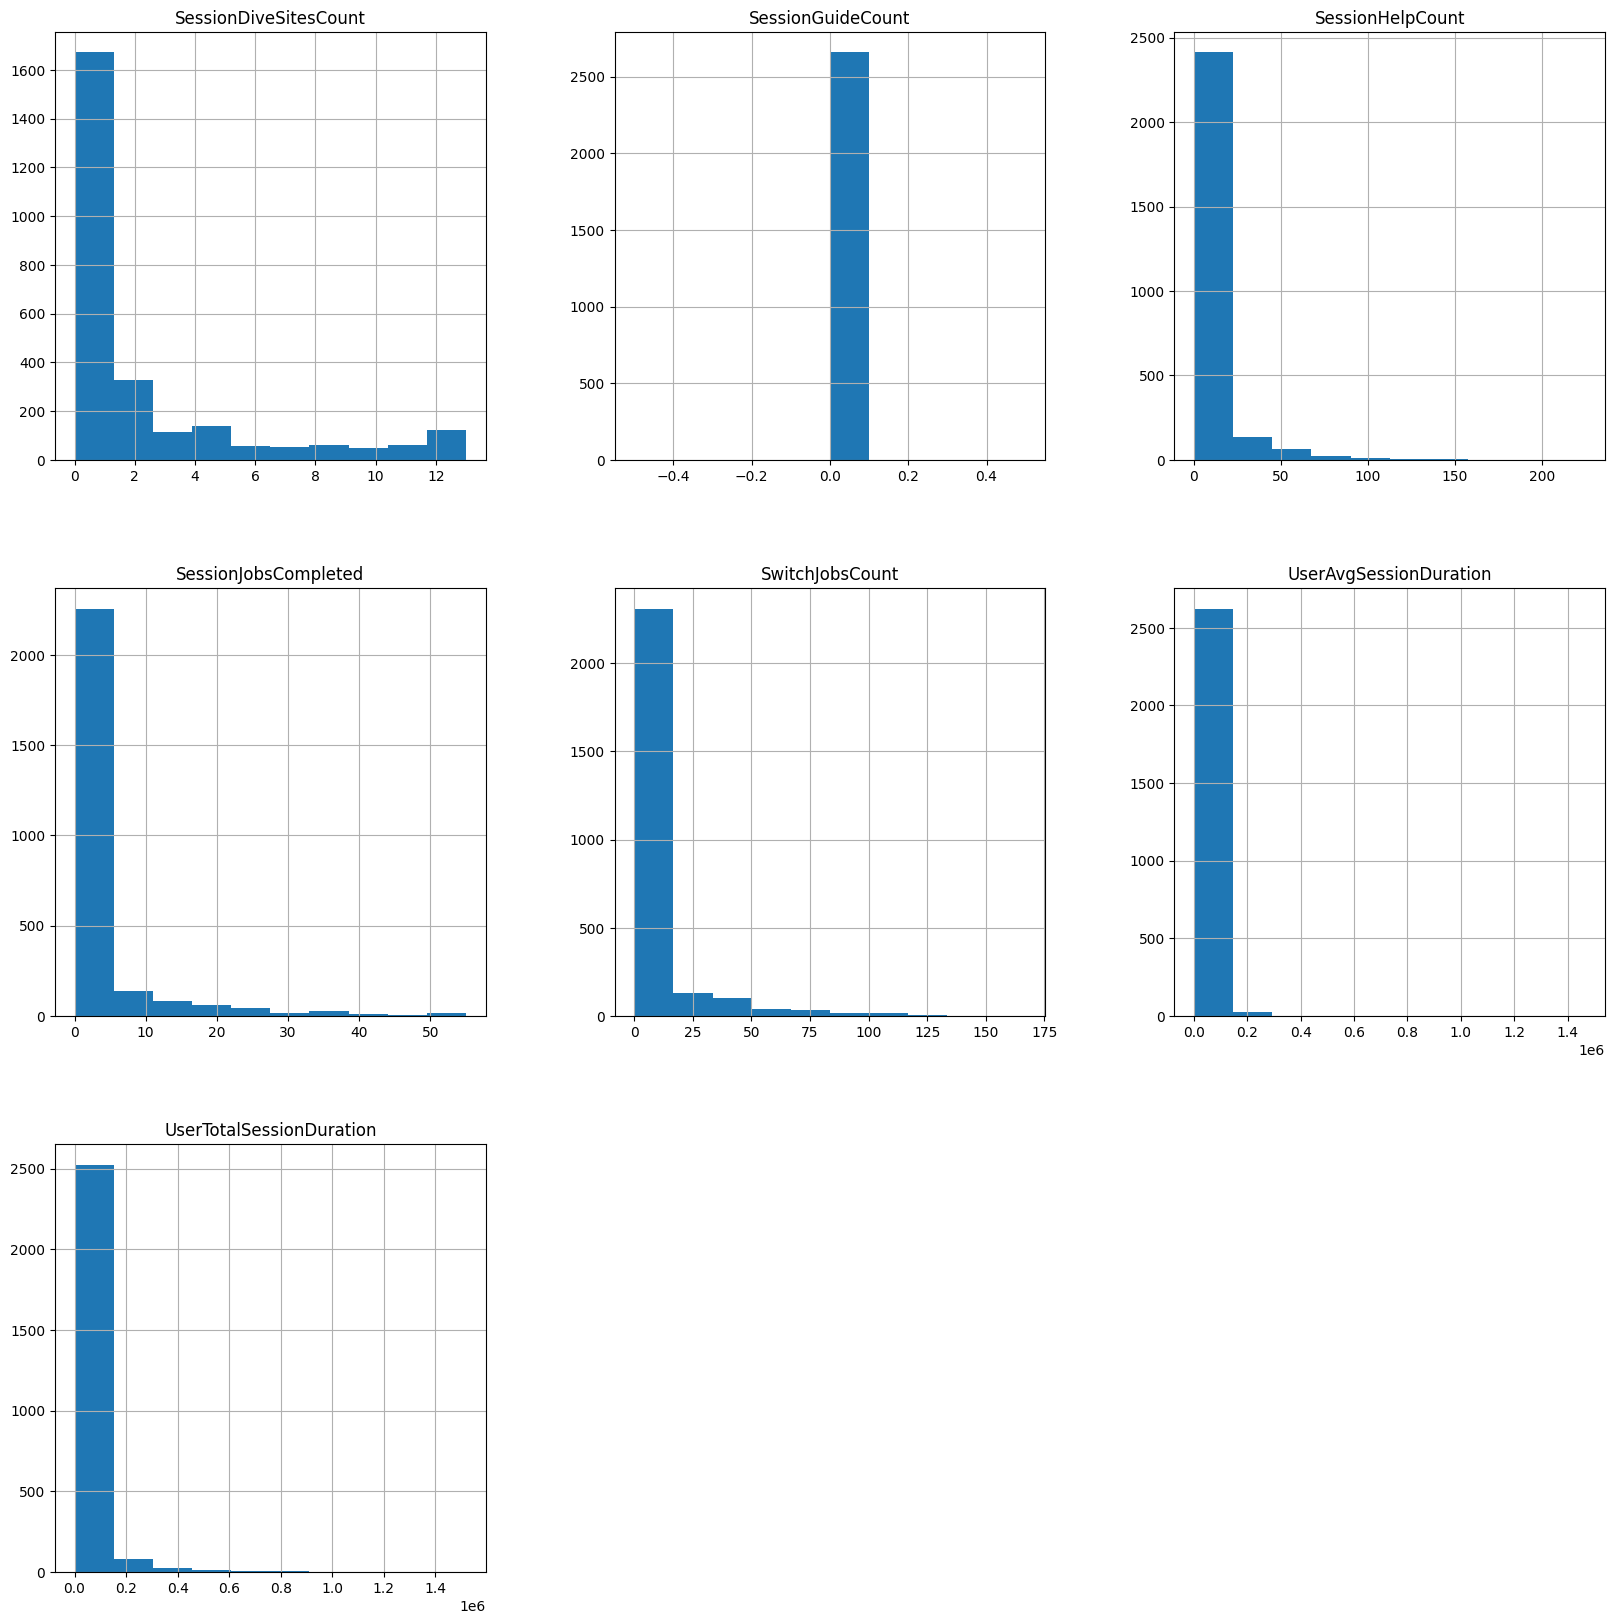

In [75]:
target_cols = ['SessionDiveSitesCount', 'SessionGuideCount', 'SessionHelpCount', 'SessionJobsCompleted', 'SwitchJobsCount', 'UserAvgSessionDuration', 'UserTotalSessionDuration']
        
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_Aggregate[target_cols].hist(ax=ax)

Heatmap across columns x,y,z...

<Axes: >

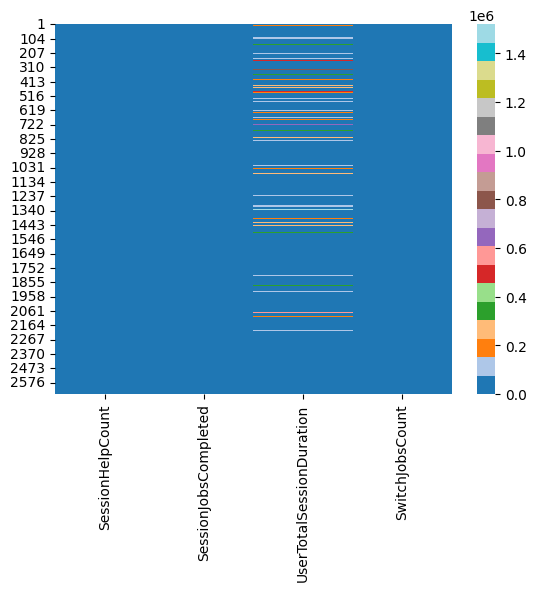

In [76]:
features1= ['SessionHelpCount','SessionJobsCompleted','UserTotalSessionDuration', 'SwitchJobsCount']

sns.heatmap(data = df_Aggregate[features1], cmap = 'tab20')